<a href="https://colab.research.google.com/github/martagarnt/sbi_pyt_pocketfinder/blob/main/CNN_Pocket_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **What Is Transfer Learning ?**
If not for Transfer Learning, Machine Learning is a pretty tough thing to do for an absolute beginner. At the lowest level, machine learning involves computing a function that maps some inputs to their corresponding outputs. Though the function itself is just a bunch of addition and multiplication operations, when passed through a non linear activation function and stacking a bunch of these layers together, functions can be made, to learn literally anything, Provided there’s enough data to learn from, and an enormous amount of computational power.

### *Welcome to Deep Learning.*

Convolutional Neural Networks can learn extremely complex mapping functions when trained on enough data. We can’t yet understand how a convolutional net learns such complicated functions.

At a base level, the weights of a CNN (Convolutional Neural Network) consist of **filters**. Think of a filter as an (**n*n**) matrix which consists of certain numbers. Now this filter is **convoluted(slide and multiply)** through the provided image. Assume the input image is of size (10,10) and the filter is of size (3,3), first the filter is multiplied with the 9 pixels on the top-left of the input image, this multiplication produces another (3,3) matrix. The values of the 9 pixels of this matrix are summed up and this value becomes a single pixel value on the top-left of **layer_2** of the CNN.

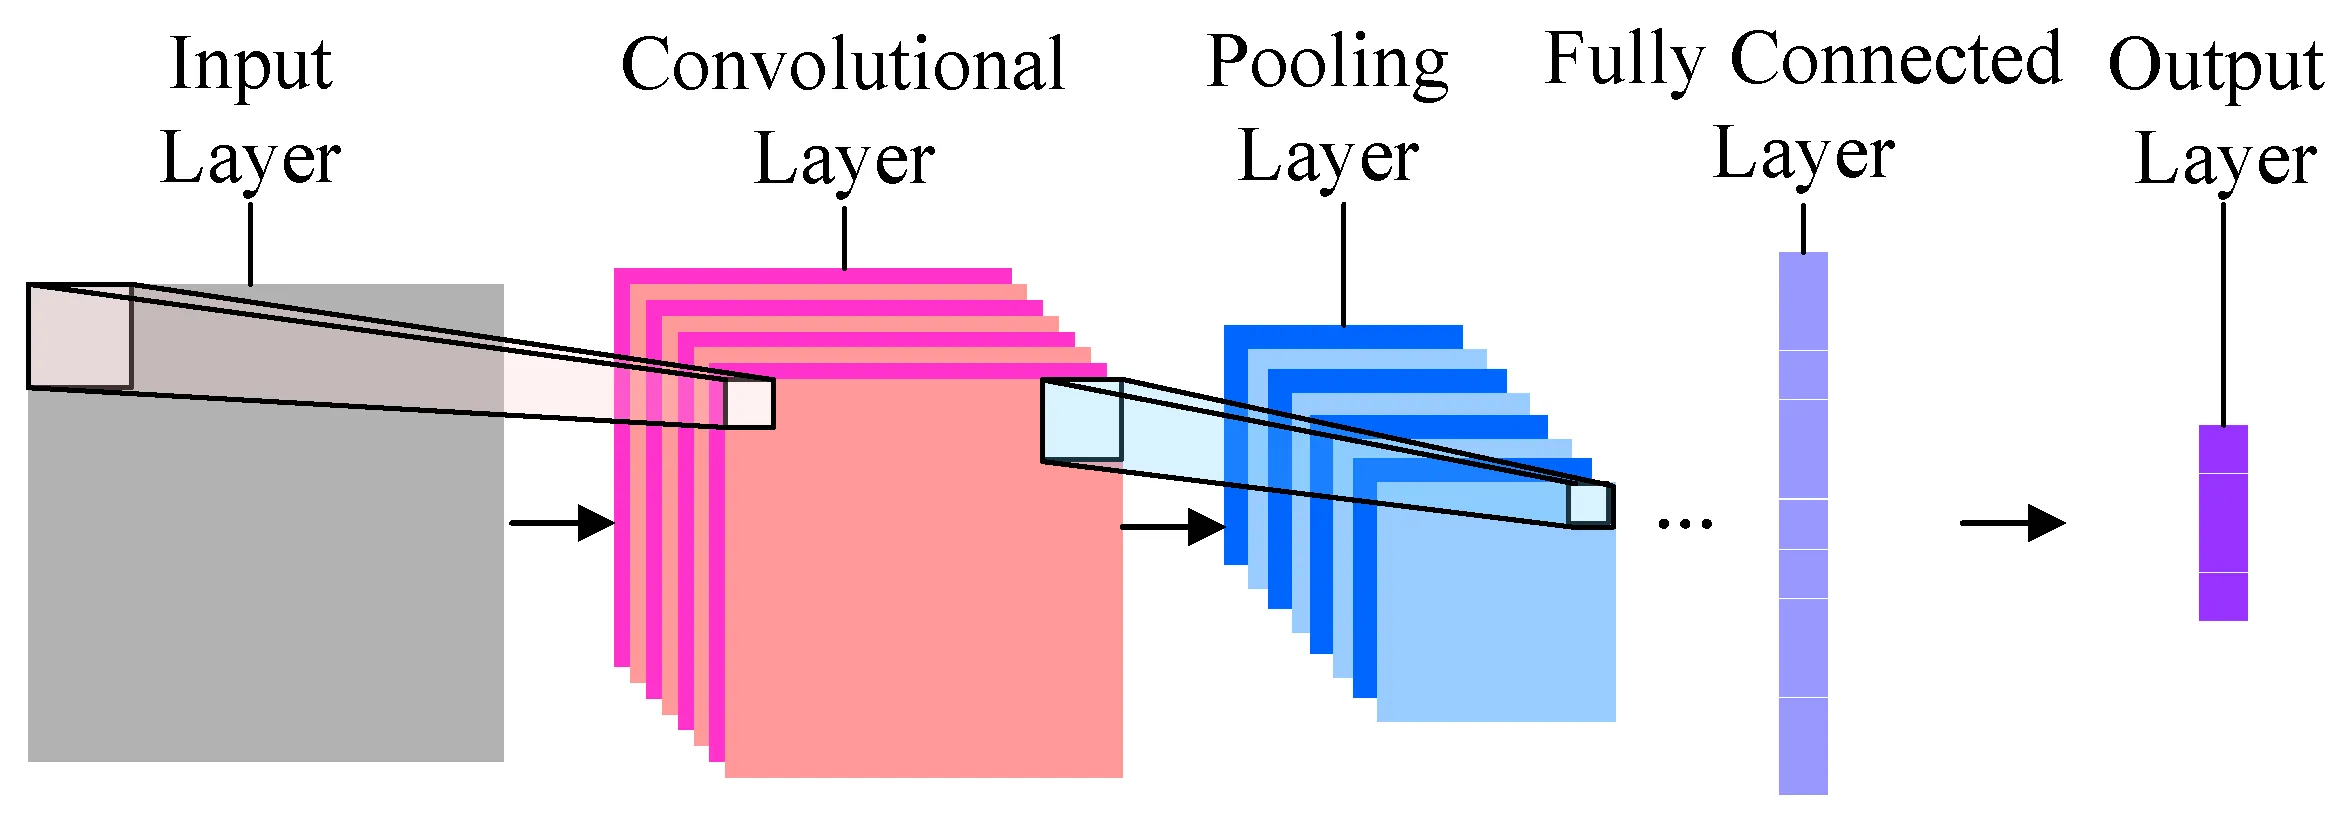

**Basically the training of a CNN involves, finding of the right values on each of the filters so that an input image when passed through the multiple layers, activates certain neurons of the last layer so as to predict the correct class.**

Though training a CNN from scratch is possible for small projects, most applications require the training of very large CNN’s and this as you guessed, takes extremely huge amounts of processed data and computational power. And both of these are not found so easily these days.

**That’s where transfer learning comes into play.** In transfer learning, we take the pre-trained weights of an already trained model(one that has been trained on millions of images belonging to 1000’s of classes, on several high power GPU’s for several days) and use these already learned features to predict new classes.

> ***The advantages of transfer learning are that:***

> *   ***1: There is no need of an extremely large training dataset.***
> *   ***2: Not much computational power is required.As we are using pre-trained weights and only have to learn the weights of the last few layers.***

There are several models that have been trained on the image net dataset and have been open sourced.

For example, VGG-16, VGG-19, Inception-V3 etc. For more details about each of these models, read the official keras documentation [here](https://keras.io/api/applications/).

Some popular backbones for computer vision (CV) problems currently are:

*   ResNet (Residual Network)
*   DenseNet
*   EfficientNet

Respectively, some popular backbones for natural language processing (NLP) problems are:

*   BERT (Bidirectional Encoder Representations from Transformers)
*   RoBERTa (Robustly Optimized BERT Pretraining Approach)
*   DeBERTa (Decoding-enhanced BERT with disentangled attention)


Other great models from facebook research projects that can be used and adapted to your needs:
- https://github.com/facebookresearch

Of course, Transfer Learning is only possible due to researchers sharing their model checkpoints for the benefit of others

In [1]:
! pip install -q scikit-learn matplotlib tensorflow numpy

In [2]:
! pip install Bio

In [3]:
# Write a toy protein PDB file
with open("protein_dummy.pdb", "w") as f:
    f.write("""\
ATOM      1  CA  ALA A   1       5.000   5.000   5.000  1.00  0.00           C
ATOM      2  CA  GLY A   2       7.000   5.000   5.000  1.00  0.00           C
ATOM      3  CA  SER A   3       6.000   7.000   5.000  1.00  0.00           C
ATOM      4  CA  THR A   4       5.000   6.000   7.000  1.00  0.00           C
END
""")

# Write a toy pocket PDB file (subset of protein)
with open("pocket_dummy.pdb", "w") as f:
    f.write("""\
ATOM      1  CA  ALA A   1       5.000   5.000   5.000  1.00  0.00           C
END
""")


✅ Step 1: Voxelization of the Protein

🎯 Goal:
Convert the 3D coordinates of protein atoms into a 3D grid (e.g., 32×32×32) with multiple channels, like:

Atom type (C, N, O, S, etc.)

Charge

Hydrophobicity

Optional: electrostatics, B-factor, etc.

### Load the necessary libraries

The following code imports the packages needed for this example.

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

print('Check GPU runtime type... ')
if len(tf.config.list_physical_devices('GPU')) == 0:
  print('Change Runtype Type in top menu for GPU acceleration')
  print(' "Runtime" -> "Change Runtime Type" -> "GPU"')
else:
  print('OK!')

Check GPU runtime type... 
OK!


In [5]:
import numpy as np
from Bio.PDB import PDBParser

GRID_SIZE = 32
VOXEL_SIZE = 1.0  # in Å
CHANNELS = ['C', 'N', 'O', 'S']  # atom types you care about

def initialize_grid():
    return np.zeros((len(CHANNELS), GRID_SIZE, GRID_SIZE, GRID_SIZE), dtype=np.float32)

def atom_to_voxel(coord, origin, voxel_size):
    return tuple(((coord - origin) / voxel_size).astype(int))

In [6]:
import torch
import torch.nn as nn

class Pocket3DCNN(nn.Module):
    def __init__(self, in_channels=4):  # 4 = atom types: C, N, O, S
        super(Pocket3DCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv3d(in_channels, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(inplace=True),

            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(inplace=True),

            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU(inplace=True),

            nn.Conv3d(128, 1, kernel_size=1),  # 1 output channel = binary classification
            nn.Sigmoid()  # voxel-wise output
        )

    def forward(self, x):
        return self.model(x)  # output shape: (batch, 1, D, H, W)


In [7]:
import torch
from torch.utils.data import Dataset
import numpy as np
import os

class PocketGridDataset(Dataset):
    def __init__(self, protein_paths, pocket_paths, grid_size=32, voxel_size=1.0):
        self.protein_paths = protein_paths
        self.pocket_paths = pocket_paths
        self.grid_size = grid_size
        self.voxel_size = voxel_size

    def __len__(self):
        return len(self.protein_paths)

    def __getitem__(self, idx):
        protein_pdb = self.protein_paths[idx]
        pocket_pdb = self.pocket_paths[idx]

        protein_grid, origin = voxelize_structure(protein_pdb, return_origin=True,
                                                  grid_size=self.grid_size,
                                                  voxel_size=self.voxel_size)
        label_grid = generate_label_grid(pocket_pdb, origin,
                                         grid_size=self.grid_size,
                                         voxel_size=self.voxel_size)

        # Convert to tensors
        X = torch.tensor(protein_grid, dtype=torch.float32)
        Y = torch.tensor(label_grid, dtype=torch.float32).unsqueeze(0)

        return X, Y


In [8]:
import numpy as np
from Bio.PDB import PDBParser

def voxelize_structure(pdb_path, origin=None, grid_size=32, voxel_size=1.0, channels=['C', 'N', 'O', 'S'], return_origin=False):
    """
    Converts a protein PDB file into a 3D voxel grid.

    Parameters:
        pdb_path (str): Path to the protein PDB file.
        origin (np.array or None): If None, automatically center the grid around the structure.
        grid_size (int): Number of voxels along each axis.
        voxel_size (float): Size of each voxel in Å.
        channels (list): Atom types to consider (default: C, N, O, S).
        return_origin (bool): If True, also return the grid origin used.

    Returns:
        grid (np.array): 4D array of shape (channels, D, H, W)
        origin (np.array): [Only if return_origin=True] The origin used to align the grid.
    """
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("structure", pdb_path)

    if origin is None:
        coords = np.array([atom.coord for atom in structure.get_atoms()])
        origin = coords.mean(axis=0) - (grid_size * voxel_size / 2)

    grid = np.zeros((len(channels), grid_size, grid_size, grid_size), dtype=np.float32)

    for atom in structure.get_atoms():
        atom_type = atom.element.strip()
        if atom_type not in channels:
            continue
        idx = channels.index(atom_type)
        coord = np.array(atom.coord)
        voxel = ((coord - origin) / voxel_size).astype(int)
        if all(0 <= v < grid_size for v in voxel):
            grid[idx, voxel[0], voxel[1], voxel[2]] += 1

    return (grid, origin) if return_origin else grid


In [9]:
def generate_label_grid(pocket_pdb_path, origin, grid_size=32, voxel_size=1.0):
    from Bio.PDB import PDBParser
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("pocket", pocket_pdb_path)
    label_grid = np.zeros((grid_size, grid_size, grid_size), dtype=np.uint8)

    for atom in structure.get_atoms():
        coord = np.array(atom.coord)
        voxel = ((coord - origin) / voxel_size).astype(int)
        if all(0 <= v < grid_size for v in voxel):
            label_grid[voxel[0], voxel[1], voxel[2]] = 1

    return label_grid


In [10]:
# List of example file paths — one protein and its pocket
protein_paths = ["protein_dummy.pdb"]
pocket_paths = ["pocket_dummy.pdb"]


In [11]:
from torch.utils.data import DataLoader
'''
model = Pocket3DCNN(in_channels=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()

dataset = PocketGridDataset(protein_paths, pocket_paths)
loader = DataLoader(dataset, batch_size=2, shuffle=True)

for epoch in range(10):
    model.train()
    for X, Y in loader:
        pred = model(X)
        loss = criterion(pred, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")
'''

'\nmodel = Pocket3DCNN(in_channels=4)\noptimizer = torch.optim.Adam(model.parameters(), lr=1e-3)\ncriterion = nn.BCELoss()\n\ndataset = PocketGridDataset(protein_paths, pocket_paths)\nloader = DataLoader(dataset, batch_size=2, shuffle=True)\n\nfor epoch in range(10):\n    model.train()\n    for X, Y in loader:\n        pred = model(X)\n        loss = criterion(pred, Y)\n\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n\n    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")\n'

In [12]:
import torch

# Step 1: Voxelize the protein and get the origin
protein_grid, origin = voxelize_structure("protein_dummy.pdb", return_origin=True)

# Step 2: Generate the label grid using the same origin
label_grid = generate_label_grid("pocket_dummy.pdb", origin)

# Step 3: Convert to PyTorch tensors and format for CNN input
# Shape for CNN: X = (batch, channels, D, H, W), Y = (batch, 1, D, H, W)

X = torch.tensor(protein_grid, dtype=torch.float32).unsqueeze(0)  # (1, C, D, H, W)
Y = torch.tensor(label_grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)

# Step 4: Run the model (make sure the model is already defined and on the right device)
model = Pocket3DCNN(in_channels=4)
output = model(X)

# Step 5: Compute loss (e.g., for one example)
criterion = torch.nn.BCELoss()
loss = criterion(output, Y)
print(f"Loss: {loss.item():.4f}")


Loss: 0.7309


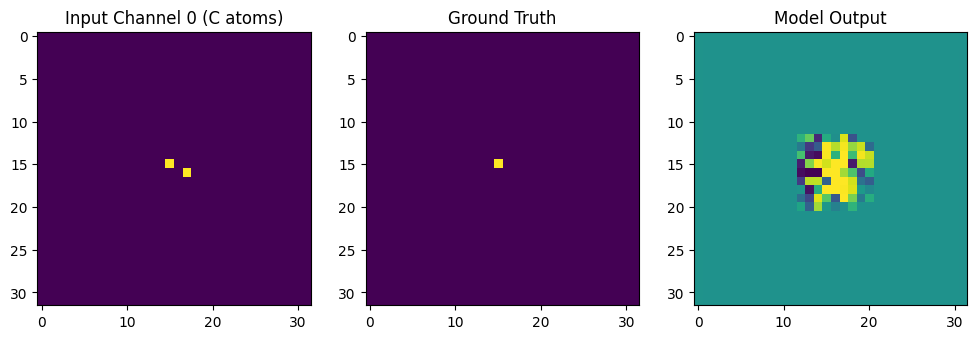

In [13]:
nonzero_voxels = torch.nonzero(Y[0, 0])  # get nonzero positions in label grid
slice_idx = nonzero_voxels[0][2] # grabs the z-index (slice number) of the first nonzero voxel

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(X[0, 0, slice_idx].detach().numpy())
axs[0].set_title("Input Channel 0 (C atoms)")

axs[1].imshow(Y[0, 0, slice_idx].detach().numpy())
axs[1].set_title("Ground Truth")

axs[2].imshow(output[0, 0, slice_idx].detach().numpy())
axs[2].set_title("Model Output")
plt.show()


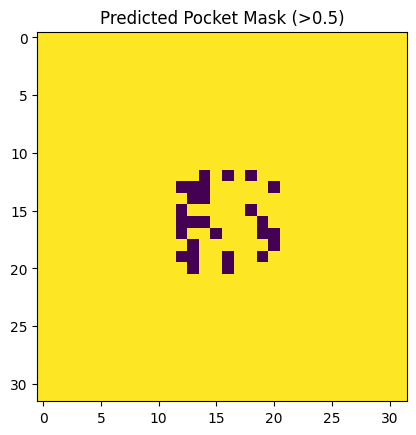

In [14]:
pred_mask = (output > 0.5).float()

plt.imshow(pred_mask[0, 0, slice_idx].detach().numpy())
plt.title("Predicted Pocket Mask (>0.5)")
plt.show()


In [15]:
def save_predicted_pocket_to_pdb(pred_grid, origin, voxel_size, pdb_filename, threshold=0.5):
    """
    Save predicted pocket voxels as pseudo-atoms in a PDB file.

    pred_grid: 3D numpy array or PyTorch tensor of shape (D, H, W)
    origin: 3D coordinate of voxel grid origin (numpy array or list)
    """
    if torch.is_tensor(pred_grid):
        pred_grid = pred_grid.squeeze().detach().cpu().numpy()

    with open(pdb_filename, 'w') as f:
        atom_index = 1
        for x in range(pred_grid.shape[0]):
            for y in range(pred_grid.shape[1]):
                for z in range(pred_grid.shape[2]):
                    if pred_grid[x, y, z] > threshold:
                        coord = origin + np.array([x, y, z]) * voxel_size
                        f.write(
                            f"HETATM{atom_index:5d}  X   UNK     1    "
                            f"{coord[0]:8.3f}{coord[1]:8.3f}{coord[2]:8.3f}  1.00  0.00           X\n"
                        )
                        atom_index += 1
        f.write("END\n")


In [16]:
# Fake prediction = use label grid as if it were model output
predicted_voxels = torch.tensor(label_grid).float()

# Save prediction to PDB
save_predicted_pocket_to_pdb(
    pred_grid=predicted_voxels,
    origin=origin,
    voxel_size=1.0,
    pdb_filename="predicted_dummy_pocket.pdb",
    threshold=0.5
)


In [17]:
import torch
'''
# Step 1: Voxelize the protein and get the origin
protein_grid, origin = voxelize_structure("1a1e_protein.pdb", return_origin=True)

# Step 2: Generate the label grid using the same origin
label_grid = generate_label_grid("1a1e_pocket.pdb", origin)

# Step 3: Convert to PyTorch tensors and format for CNN input
# Shape for CNN: X = (batch, channels, D, H, W), Y = (batch, 1, D, H, W)

X = torch.tensor(protein_grid, dtype=torch.float32).unsqueeze(0)  # (1, C, D, H, W)
Y = torch.tensor(label_grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)

# Step 4: Run the model (make sure the model is already defined and on the right device)
model = Pocket3DCNN(in_channels=4)
output = model(X)

# Step 5: Compute loss (e.g., for one example)
criterion = torch.nn.BCELoss()
loss = criterion(output, Y)
print(f"Loss: {loss.item():.4f}")

predicted_voxels = torch.tensor(label_grid).float()

# Save prediction to PDB
save_predicted_pocket_to_pdb(
    pred_grid=predicted_voxels,
    origin=origin,
    voxel_size=1.0,
    pdb_filename="predicted_1a1e_pocket.pdb",
    threshold=0.5
)
'''

'\n# Step 1: Voxelize the protein and get the origin\nprotein_grid, origin = voxelize_structure("1a1e_protein.pdb", return_origin=True)\n\n# Step 2: Generate the label grid using the same origin\nlabel_grid = generate_label_grid("1a1e_pocket.pdb", origin)\n\n# Step 3: Convert to PyTorch tensors and format for CNN input\n# Shape for CNN: X = (batch, channels, D, H, W), Y = (batch, 1, D, H, W)\n\nX = torch.tensor(protein_grid, dtype=torch.float32).unsqueeze(0)  # (1, C, D, H, W)\nY = torch.tensor(label_grid, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, D, H, W)\n\n# Step 4: Run the model (make sure the model is already defined and on the right device)\nmodel = Pocket3DCNN(in_channels=4)\noutput = model(X)\n\n# Step 5: Compute loss (e.g., for one example)\ncriterion = torch.nn.BCELoss()\nloss = criterion(output, Y)\nprint(f"Loss: {loss.item():.4f}")\n\npredicted_voxels = torch.tensor(label_grid).float()\n\n# Save prediction to PDB\nsave_predicted_pocket_to_pdb(\n    pred_grid=

In [18]:
'''
# Voxelize protein
protein_grid, origin = voxelize_structure("1a1e_protein.pdb", return_origin=True)

# Generate label grid
label_grid = generate_label_grid("1a1e_pocket.pdb", origin)

# Fake prediction = use label grid as if it were model output
predicted_voxels = torch.tensor(label_grid).float()

# Save prediction to PDB
save_predicted_pocket_to_pdb(
    pred_grid=predicted_voxels,
    origin=origin,
    voxel_size=1.0,
    pdb_filename="predicted_1a1e_pocket.pdb",
    threshold=0.5
)
'''

'\n# Voxelize protein\nprotein_grid, origin = voxelize_structure("1a1e_protein.pdb", return_origin=True)\n\n# Generate label grid\nlabel_grid = generate_label_grid("1a1e_pocket.pdb", origin)\n\n# Fake prediction = use label grid as if it were model output\npredicted_voxels = torch.tensor(label_grid).float()\n\n# Save prediction to PDB\nsave_predicted_pocket_to_pdb(\n    pred_grid=predicted_voxels,\n    origin=origin,\n    voxel_size=1.0,\n    pdb_filename="predicted_1a1e_pocket.pdb",\n    threshold=0.5\n)\n'

In [19]:
import os
import glob

def collect_pdb_pairs(dataset_root):
    protein_paths = []
    pocket_paths = []

    # Loop through all subdirectories (each one is a complex)
    for pdb_dir in sorted(os.listdir(dataset_root)):
        full_path = os.path.join(dataset_root, pdb_dir)
        if not os.path.isdir(full_path):
            continue  # skip files

        # Find *_protein.pdb and *_pocket.pdb
        protein_pdb = glob.glob(os.path.join(full_path, "*_protein.pdb"))
        pocket_pdb = glob.glob(os.path.join(full_path, "*_pocket.pdb"))

        # Basic sanity check
        if protein_pdb and pocket_pdb:
            protein_paths.append(protein_pdb[0])
            pocket_paths.append(pocket_pdb[0])

    return protein_paths, pocket_paths


In [20]:
#!pip install gdown
#!gdown 1mtU0n_-ejTE9yA_G7iuOQJ4BCs9FVUhs --output dataset.zip


In [21]:
#!unzip dataset.zip

In [22]:
dataset_root = "/content/refined-set"  # e.g., "./data" or wherever your folders are
protein_paths, pocket_paths = collect_pdb_pairs(dataset_root)

print(f"Found {len(protein_paths)} protein-pocket pairs.")

# Now feed into your dataset
from torch.utils.data import DataLoader

dataset = PocketGridDataset(protein_paths, pocket_paths, grid_size=32, voxel_size=1.0)
loader = DataLoader(dataset, batch_size=2, shuffle=True)


Found 5316 protein-pocket pairs.


In [23]:
X, Y = dataset[0]
print("Input shape:", X.shape)  # should be (channels, 32, 32, 32)
print("Label shape:", Y.shape)  # should be (1, 32, 32, 32)
print("Pocket voxels in label:", Y.sum().item())


Input shape: torch.Size([4, 32, 32, 32])
Label shape: torch.Size([1, 32, 32, 32])
Pocket voxels in label: 367.0


In [24]:
model = Pocket3DCNN(in_channels=4)

# Grab one sample from the dataset
X, Y = dataset[0]

# Make sure it's shaped for the model: (1, C, D, H, W)
X_input = X.unsqueeze(0)  # add batch dimension: (1, 4, 32, 32, 32)

# Run the model
model.eval()
with torch.no_grad():
    preds = model(X_input)[0]  # remove batch dimension again → shape: (1, 32, 32, 32)

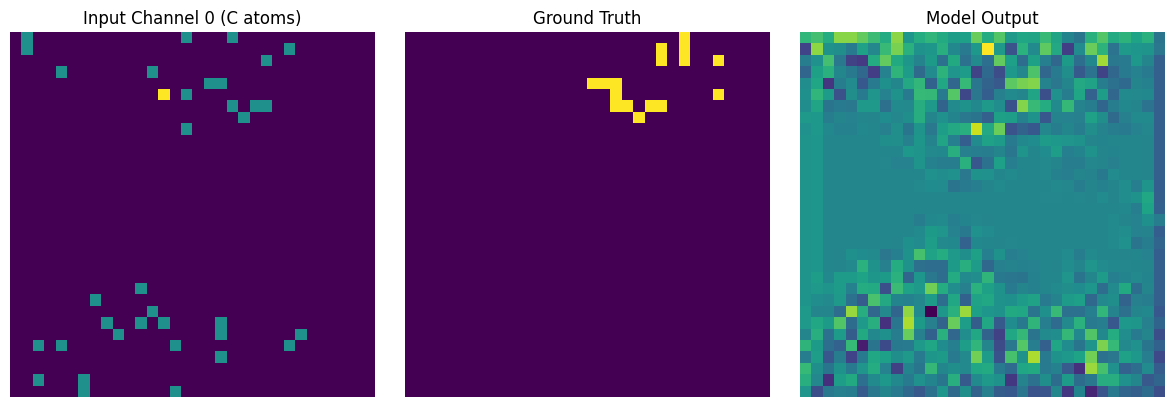

In [25]:
import matplotlib.pyplot as plt

# Pick a Z slice that contains pocket voxels
nonzero_voxels = torch.nonzero(Y[0])
slice_idx = nonzero_voxels[0][1] if len(nonzero_voxels) > 0 else 16  # fallback to center

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(X[0, slice_idx, :, :].detach().numpy())
axs[0].set_title("Input Channel 0 (C atoms)")

axs[1].imshow(Y[0, slice_idx, :, :].detach().numpy())
axs[1].set_title("Ground Truth")

axs[2].imshow(preds[0, slice_idx, :, :].detach().numpy())
axs[2].set_title("Model Output")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

In [26]:
import torch.nn as nn

def dice_loss(pred, target, smooth=1e-8):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

In [27]:
print("Using GPU?", torch.cuda.is_available())


Using GPU? True


In [35]:
import time

num_epochs=12
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for i, (X, Y) in enumerate(loader):
        batch_start = time.time()

        X, Y = X.to(device), Y.to(device)
        preds = model(X)
        loss = dice_loss(preds, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        batch_time = time.time() - batch_start
        if i % 100 == 0:  # log every 100 batches
          print(f"Batch {i+1}/{len(loader)} | Loss: {loss.item():.4f} | Time: {batch_time:.2f}s")

    print(f"Epoch {epoch+1} complete.\n")


Batch 1/2658 | Loss: 0.6794 | Time: 0.07s
Batch 101/2658 | Loss: 0.6515 | Time: 0.04s
Batch 201/2658 | Loss: 0.4920 | Time: 0.07s
Batch 301/2658 | Loss: 0.4714 | Time: 0.06s


KeyboardInterrupt: 

In [ ]:
# Pick a Z slice that contains pocket voxels
nonzero_voxels = torch.nonzero(Y[0])
slice_idx = nonzero_voxels[0][1] if len(nonzero_voxels) > 0 else 16  # fallback to center

fig, axs = plt.subplots(1, 3, figsize=(12, 4))

axs[0].imshow(X[0, slice_idx, :, :].detach().numpy())
axs[0].set_title("Input Channel 0 (C atoms)")

axs[1].imshow(Y[0, slice_idx, :, :].detach().numpy())
axs[1].set_title("Ground Truth")

axs[2].imshow(preds[0, slice_idx, :, :].detach().numpy())
axs[2].set_title("Model Output")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()


In [ ]:
from torch.utils.data import random_split

# 80/20 split (customize if needed)
val_ratio = 0.2
num_total = len(dataset)
num_val = int(num_total * val_ratio)
num_train = num_total - num_val

train_set, val_set = random_split(dataset, [num_train, num_val])
print(f"🔧 Train: {len(train_set)} | Val: {len(val_set)}")


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_set, batch_size=2, shuffle=True)
val_loader = DataLoader(val_set, batch_size=2, shuffle=False)


In [ ]:
def dice_loss(pred, target, smooth=1e-8):
    pred = pred.view(-1)
    target = target.view(-1)
    intersection = (pred * target).sum()
    return 1 - (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)


In [ ]:
model = Pocket3DCNN(in_channels=4)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for X, Y in train_loader:
        preds = model(X)
        loss = dice_loss(preds, Y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val, Y_val in val_loader:
            val_preds = model(X_val)
            loss = dice_loss(val_preds, Y_val)
            val_loss += loss.item()

    print(f"📘 Epoch {epoch+1}/{num_epochs} | "
          f"Train Dice Loss: {train_loss / len(train_loader):.4f} | "
          f"Val Dice Loss: {val_loss / len(val_loader):.4f}")


In [ ]:
# Get one sample from the val set
X_val, Y_val = val_set[0]
X_val_input = X_val.unsqueeze(0)

model.eval()
with torch.no_grad():
    val_pred = model(X_val_input)[0]

In [ ]:
X_train, Y_train = train_set[0]
X_train_input = X_train.unsqueeze(0)

with torch.no_grad():
    train_pred = model(X_train_input)[0]

In [ ]:
# Get a slice where the ground truth has pocket voxels
nonzero_voxels = torch.nonzero(Y_val[0])  # shape: (N, 3)
if len(nonzero_voxels) > 0:
    slice_idx = nonzero_voxels[0][1].item()  # Y_val is (1, D, H, W)
else:
    print("⚠️ No pocket voxels found in this sample")
    slice_idx = 16  # fallback

print(f"Using slice {slice_idx}")


In [ ]:
axs[0].imshow(X_val[0, slice_idx, :, :].detach().numpy(), cmap='gray')
axs[1].imshow(Y_val[0, slice_idx, :, :].detach().numpy(), cmap='gray')
axs[2].imshow(val_pred[0, slice_idx, :, :].detach().numpy(), cmap='hot')


In [ ]:
# Pick a Z slice that contains pocket voxels
nonzero_voxels = torch.nonzero(Y[0])
#slice_idx = nonzero_voxels[0][1] if len(nonzero_voxels) > 0 else 16  # fallback to center
slice_idx = 23
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Input (e.g., C atoms)
axs[0].imshow(X_val[0, slice_idx, :, :].detach().numpy(), cmap='Pastel1')
axs[0].set_title("Input Channel 0 (C atoms)")

# Ground Truth
axs[1].imshow(Y_val[0, slice_idx, :, :].detach().numpy(), cmap='Pastel1')
axs[1].set_title("Ground Truth Pocket")

# Model Prediction
axs[2].imshow(val_pred[0, slice_idx, :, :].detach().numpy(), cmap='Pastel1')
axs[2].set_title("Model Prediction")

for ax in axs: ax.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)


### Visualize some images

In [ ]:
# Show the first nine images and labels from the training set

class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


### Data Augmentation

Since we have very little training data it makes sense to use some data augmentation for training. This will help preventing overfitting by introducing image sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping.

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])


In [ ]:
# Apply the data augmentation layers 9 times to the same image to see the results.

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')



 <font color='blue'> Can you think of other Data Augmentation techniques not mentioned here that might be useful?

_yourresponse_


## Initialize the ResNet model

We will use the [`Resnet50`](https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50) model, and set the `weights` parameter to `'imagenet'` to load the pre-trained weights on ImageNet.

When we print the arquitecture of the model, we see that the last layer is a fully connected (`Dense`) layer with 1000 output neurons as shown below:


   `predictions (Dense)             (None, 1000)`

In [ ]:
# Create the base model from the pre-trained model ResNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               weights='imagenet')

print(base_model.summary())

 <font color='blue'> Could you *briefly* explain what is the difference between those layers: Flatten, Dropout, Dense and MaxPooling?

_yourresponse_

 <font color='blue'> What is the input layer? its size? and the output layer? its size?

yourresponse

By specifying the `include_top=False` and `pooling='avg'` arguments, we load a network that doesn't include the classification layer at the top, which is ideal for transfer learning.



In [ ]:
# Create the base model from the pre-trained model ResNet
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.ResNet50(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               pooling='avg',
                                               weights='imagenet')

print(base_model.summary())

Now the base model converts each 224x224x3 image into a 2048-d feature vector:

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
print(image_batch.shape)
feature_batch = base_model(image_batch)
print(feature_batch.shape)


<font color='blue'> Why do we use a pre-trained model like ResNet50 instead of building one from scratch? In what situations would it be beneficial to use a pre-trained model in a clinical context?

_your response_

## Feature extraction

In this step, we will freeze the convolutional base created from the previous step to use it as a feature extractor. Then we will add a classification layer on top of it and train it using our training data.

In [ ]:
# prevent the weights in a given layer from being updated during training
base_model.trainable = False


In [ ]:
# add a classification layer
# for two classes we only need one output neuron (positive numbers predict class 1, negative numbers predict class 0)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)


### Build the model

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print(model.summary())


### Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


<font color='blue'> Which are the number of: epochs, batches and iterations?

_response_

### Train the model

In [ ]:
history = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset)


Plot the learning curves:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


<font color='blue'> Look at the learning curves after training. How can you tell if the model is overfitting?

_your response_

## Fine tuning

In the feature extraction experiment, we were only training the last `Dense` layer on top of a ResNet50 base model. The weights of the pre-trained network were **not** updated during training.

Now we will train again our model but updating all the weights at training time.

In [ ]:
# Un-freeze the base model layers
base_model.trainable = True


In [ ]:
# add a classification layer
# for two classes we only need one output neuron (positive numbers predict class 1, negative numbers predict class 0)
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)


### Build the model

In [ ]:
inputs = tf.keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

print(model.summary())


### Compile the model

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])


### Train the model

In [ ]:
history_ft = model.fit(train_dataset,
                    epochs=15,
                    validation_data=validation_dataset)


Plot the learning curves and compare with the model trained with feature extraction:

In [ ]:
acc_ft = history_ft.history['accuracy']
val_acc_ft = history_ft.history['val_accuracy']
loss_ft = history_ft.history['loss']
val_loss_ft = history_ft.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy (Feat. extraction)')
plt.plot(val_acc, label='Validation Accuracy (Feat. extraction)')
plt.plot(acc_ft, label='Training Accuracy (Fine tuning)')
plt.plot(val_acc_ft, label='Validation Accuracy (Fine tuning)')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([0,1.0])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss (Feat. extraction)')
plt.plot(val_loss, label='Validation Loss (Feat. extraction)')
plt.plot(loss_ft, label='Training Loss (Fine tuning)')
plt.plot(val_loss_ft, label='Validation Loss (Fine tuning)')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


We appreciate that while the final validation accuracy is quite similar in both models, the model trained with fine-tuning is more prone to overfitting. Which makes sense given the small size of the training dataset. Choosing one technique or another depends on many aspects, such as the model architecture, the size of the training data, and/or how similar are the source and target tasks.

<font color='blue'> Look at the learning curves after training and comparing. Is the same conclusion what you see on the plots?

### Additional References

- [Tensorflow transfer learning and fine-tuning guide](https://www.tensorflow.org/guide/keras/transfer_learning)
- [Transfer Learning page at the Stanford CS class CS231n: Convolutional Neural Networks for Visual Recognition.](https://cs231n.github.io/transfer-learning/)